<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/clickbait_image_tfrec_mobilenet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import os, sys, math
import numpy as np
import random
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

import sys

#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')
from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

#Configurations

In [ ]:
PATH_OUTPUT = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/tfrec/tfrec_data/'

TARGET_SIZE = [180, 180]
CLASSES = ['nonclickbaits', 'clickbaits'] 
BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)
VALIDATION_SPLIT = 0.3
TESTING_SPLIT = 0.5
WIDTH = 180
HEIGHT = 180

MODEL_SAVE_PATH ='/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models'

#base model with all layers freezed
simple_mobilenet_v2_path = os.path.join(MODEL_SAVE_PATH, 'simple_mobilenet_v2_model')

#base model with all layers freezed and model with data augmentation
simple_mobilenet_v2_with_data_aug_path = os.path.join(MODEL_SAVE_PATH, 'simple_mobilenet_v2_model_aug')

#base model lower layers freezed and upper layers unfreezed 
mobilenet_v2_path = os.path.join(MODEL_SAVE_PATH, 'mobilenet_v2_model')

#base model lower layers freezed and upper layers unfreezed alongwith data augmentation
mobilenet_v2_aug_path = os.path.join(MODEL_SAVE_PATH, 'mobilenet_v2_model_aug')

In [ ]:
#instantiate read_data utility
read_data = read_tfrec_data(PATH_OUTPUT,TARGET_SIZE=TARGET_SIZE, MODE=0)

In [ ]:
# splitting data files between training, validation and test
filenames, training_filenames, validation_filenames, testing_filenames = read_data.get_tfrec_files()

validation_steps = int(15572 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(15572 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 12 training files , 2 validation files and 2 test files
With a batch size of 32, there will be 364 batches per training epoch and 60 batch(es) per validation run.


#Load data

In [ ]:
# instantiate the datasets
train_ds = read_data.get_batched_dataset(training_filenames, train=True)
val_ds = read_data.get_batched_dataset(validation_filenames, train=False)
test_ds = read_data.get_batched_dataset(testing_filenames, train=False)

In [ ]:
#@title "Speed test"
for image, class_num in train_ds.take(1):
  for i in range(32):
    print(f"Image shape {image[i].shape}, Class={class_num[i]}, Label={CLASSES[class_num[i]]}")

Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shap

#Build and compile model

##Simple model

In [ ]:
s_base_model, simple_mobilenet_v2_model = mh.create_mobilenet_v2_model(IMG_SIZE=(WIDTH,HEIGHT))
simple_mobilenet_v2_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract_5 (TFOpLamb (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               6558

##Model with data augmentation

In [ ]:
s_aug_base_model, simple_mobilenet_v2_model_with_aug = mh.create_mobilenet_v2_model(IMG_SIZE=(WIDTH,HEIGHT), augmentation=True)
mobilenet_v2_model_with_aug.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.truediv_6 (TFOpLambd (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract_6 (TFOpLamb (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1280)              0   

##Finetuned model

In [ ]:
s_ft_base_model, mobilenet_v2_model_finetuned = mh.create_mobilenet_v2_model(IMG_SIZE=(WIDTH,HEIGHT), fine_tune=True)
mobilenet_v2_model_finetuned.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf.math.truediv_10 (TFOpLamb (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract_10 (TFOpLam (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_10  (None, 1280)              0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               655

##Finetuned model with data augmentation

In [ ]:
s_aug_ft_base_model, mobilenet_v2_model_finetuned_aug = mh.create_mobilenet_v2_model(IMG_SIZE=(WIDTH,HEIGHT), fine_tune=True, augmentation=True)
mobilenet_v2_model_finetuned_aug.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.truediv_12 (TFOpLamb (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract_12 (TFOpLam (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_12  (None, 1280)              0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 1280)              0  

#Training

##Simple model

In [ ]:
simple_mobilenet_v2_model, s_mv_history = mh.compile_train_model(simple_mobilenet_v2_model,
                                                     s_base_model,
                                                     train_ds, 
                                                     val_ds,steps_per_epoch=steps_per_epoch,
                                                     validation_steps=validation_steps,
                                                     EPOCHS=20,
                                                     save_model = True,
                                                     model_save_path=simple_mobilenet_v2_path)

Epoch 1/20
364/364 [==============================] - 69s 87ms/step - loss: 0.6607 - tp: 1703.4137 - fp: 1022.5178 - tn: 2115.7890 - fn: 1014.1918 - accuracy: 0.6276 - precision: 0.6012 - recall: 0.6057 - auc: 0.6815 - prc: 0.6379 - val_loss: 0.5221 - val_tp: 589.0000 - val_fp: 213.0000 - val_tn: 841.0000 - val_fn: 277.0000 - val_accuracy: 0.7448 - val_precision: 0.7344 - val_recall: 0.6801 - val_auc: 0.8162 - val_prc: 0.7769
Epoch 2/20
364/364 [==============================] - 29s 79ms/step - loss: 0.5271 - tp: 1929.7616 - fp: 764.6466 - tn: 2378.4110 - fn: 783.0932 - accuracy: 0.7355 - precision: 0.7169 - recall: 0.7049 - auc: 0.8131 - prc: 0.7720 - val_loss: 0.5426 - val_tp: 735.0000 - val_fp: 386.0000 - val_tn: 668.0000 - val_fn: 131.0000 - val_accuracy: 0.7307 - val_precision: 0.6557 - val_recall: 0.8487 - val_auc: 0.8247 - val_prc: 0.7890
Epoch 3/20
364/364 [==============================] - 28s 76ms/step - loss: 0.4992 - tp: 1947.8027 - fp: 710.9534 - tn: 2448.8877 - fn: 748.26

##Simple model with data augmentation

In [ ]:
simple_mobilenet_v2_model_with_aug, s_mv_aug_history = mh.compile_train_model(simple_mobilenet_v2_model_with_aug,
                                                     s_aug_base_model,
                                                     train_ds, 
                                                     val_ds,steps_per_epoch=steps_per_epoch,
                                                     validation_steps=validation_steps,
                                                     EPOCHS=20,
                                                     save_model = True,
                                                     model_save_path=simple_mobilenet_v2_with_data_aug_path)

Epoch 1/20
364/364 [==============================] - 40s 90ms/step - loss: 0.7147 - tp: 2271.3781 - fp: 1348.8849 - tn: 2857.9863 - fn: 1297.6630 - accuracy: 0.6648 - precision: 0.6297 - recall: 0.6464 - auc: 0.7329 - prc: 0.6978 - val_loss: 0.5703 - val_tp: 486.0000 - val_fp: 196.0000 - val_tn: 858.0000 - val_fn: 380.0000 - val_accuracy: 0.7000 - val_precision: 0.7126 - val_recall: 0.5612 - val_auc: 0.7775 - val_prc: 0.7223
Epoch 2/20
364/364 [==============================] - 31s 85ms/step - loss: 0.5987 - tp: 1700.0822 - fp: 929.0493 - tn: 2236.2274 - fn: 990.5534 - accuracy: 0.6655 - precision: 0.6397 - recall: 0.6194 - auc: 0.7342 - prc: 0.6762 - val_loss: 0.5556 - val_tp: 634.0000 - val_fp: 311.0000 - val_tn: 743.0000 - val_fn: 232.0000 - val_accuracy: 0.7172 - val_precision: 0.6709 - val_recall: 0.7321 - val_auc: 0.7875 - val_prc: 0.7374
Epoch 3/20
364/364 [==============================] - 31s 85ms/step - loss: 0.5813 - tp: 1737.8356 - fp: 899.7288 - tn: 2283.2575 - fn: 935.09

##Finetuned model 

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
mobilenet_v2_model_finetuned, mv_finetuned_history = mh.compile_train_model(mobilenet_v2_model_finetuned,
                                                     s_ft_base_model,
                                                     train_ds, 
                                                     val_ds,steps_per_epoch=steps_per_epoch,
                                                     validation_steps=validation_steps,
                                                     EPOCHS=50,
                                                     OPTIMIZER = tf.keras.optimizers.RMSprop(lr=0.0001/10),
                                                     save_model = True,
                                                     model_save_path=mobilenet_v2_path)

Epoch 1/50
364/364 [==============================] - 52s 122ms/step - loss: 0.6524 - tp: 2335.1781 - fp: 1314.3342 - tn: 2894.8521 - fn: 1231.5479 - accuracy: 0.6724 - precision: 0.6366 - recall: 0.6609 - auc: 0.7374 - prc: 0.6911 - val_loss: 0.5169 - val_tp: 695.0000 - val_fp: 315.0000 - val_tn: 739.0000 - val_fn: 171.0000 - val_accuracy: 0.7469 - val_precision: 0.6881 - val_recall: 0.8025 - val_auc: 0.8305 - val_prc: 0.7881
Epoch 2/50
364/364 [==============================] - 42s 116ms/step - loss: 0.5115 - tp: 1970.6384 - fp: 719.5890 - tn: 2423.6356 - fn: 742.0493 - accuracy: 0.7461 - precision: 0.7290 - recall: 0.7249 - auc: 0.8257 - prc: 0.7885 - val_loss: 0.4772 - val_tp: 629.0000 - val_fp: 203.0000 - val_tn: 851.0000 - val_fn: 237.0000 - val_accuracy: 0.7708 - val_precision: 0.7560 - val_recall: 0.7263 - val_auc: 0.8539 - val_prc: 0.8179
Epoch 3/50
364/364 [==============================] - 42s 115ms/step - loss: 0.4581 - tp: 2052.7397 - fp: 606.2959 - tn: 2557.3863 - fn: 639

##Finetuned model with data augmentation

In [ ]:
mobilenet_v2_model_finetuned_aug, mv_finetuned_aug_history = mh.compile_train_model(mobilenet_v2_model_finetuned_aug,
                                                     s_aug_ft_base_model,
                                                     train_ds, 
                                                     val_ds,steps_per_epoch=steps_per_epoch,
                                                     validation_steps=validation_steps,
                                                     EPOCHS=50,
                                                     OPTIMIZER = tf.keras.optimizers.RMSprop(lr=0.0001/10),
                                                     save_model = True,
                                                     model_save_path=mobilenet_v2_aug_path)

Epoch 1/50
364/364 [==============================] - 57s 131ms/step - loss: 0.7116 - tp: 2071.4411 - fp: 1256.3507 - tn: 2946.0000 - fn: 1502.1205 - accuracy: 0.6539 - precision: 0.6313 - recall: 0.5916 - auc: 0.7191 - prc: 0.6846 - val_loss: 0.5770 - val_tp: 636.0000 - val_fp: 344.0000 - val_tn: 710.0000 - val_fn: 230.0000 - val_accuracy: 0.7010 - val_precision: 0.6490 - val_recall: 0.7344 - val_auc: 0.7762 - val_prc: 0.7189
Epoch 2/50
364/364 [==============================] - 45s 124ms/step - loss: 0.6080 - tp: 1714.2932 - fp: 942.3726 - tn: 2205.5260 - fn: 993.7205 - accuracy: 0.6662 - precision: 0.6428 - recall: 0.6227 - auc: 0.7240 - prc: 0.6647 - val_loss: 0.5639 - val_tp: 725.0000 - val_fp: 428.0000 - val_tn: 626.0000 - val_fn: 141.0000 - val_accuracy: 0.7036 - val_precision: 0.6288 - val_recall: 0.8372 - val_auc: 0.8012 - val_prc: 0.7530
Epoch 3/50
364/364 [==============================] - 45s 125ms/step - loss: 0.5716 - tp: 1840.3233 - fp: 852.9233 - tn: 2284.6356 - fn: 878

#Plot training history

##Simple model history

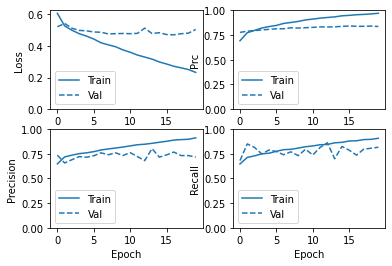

In [ ]:
vh.plot_metrics(s_mv_history, metrics = ['loss', 'prc', 'precision', 'recall'])

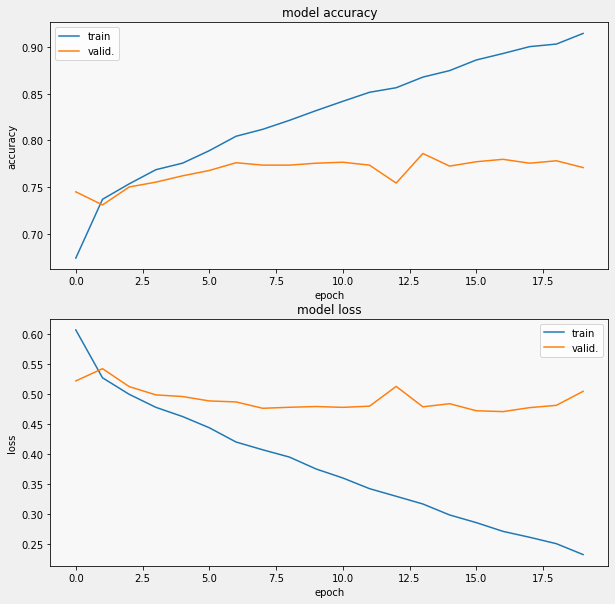

In [ ]:
vh.display_training_curves(s_mv_history.history['accuracy'], s_mv_history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(s_mv_history.history['loss'], s_mv_history.history['val_loss'], 'loss', 212)

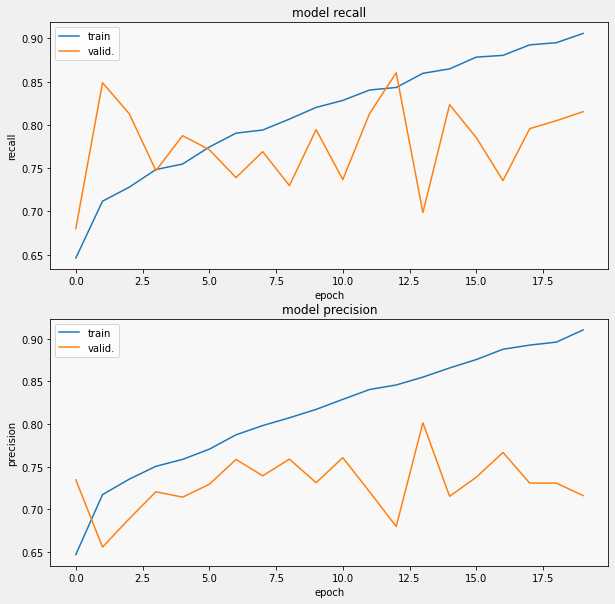

In [ ]:
vh.display_training_curves(s_mv_history.history['recall'], s_mv_history.history['val_recall'], 'recall', 211)
vh.display_training_curves(s_mv_history.history['precision'], s_mv_history.history['val_precision'], 'precision', 212)

##Simple model with augment history

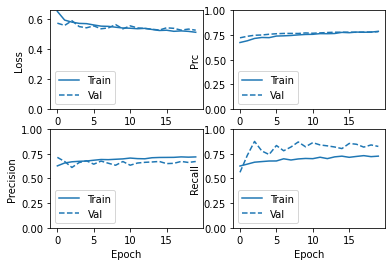

In [ ]:
vh.plot_metrics(s_mv_aug_history, metrics = ['loss', 'prc', 'precision', 'recall'])

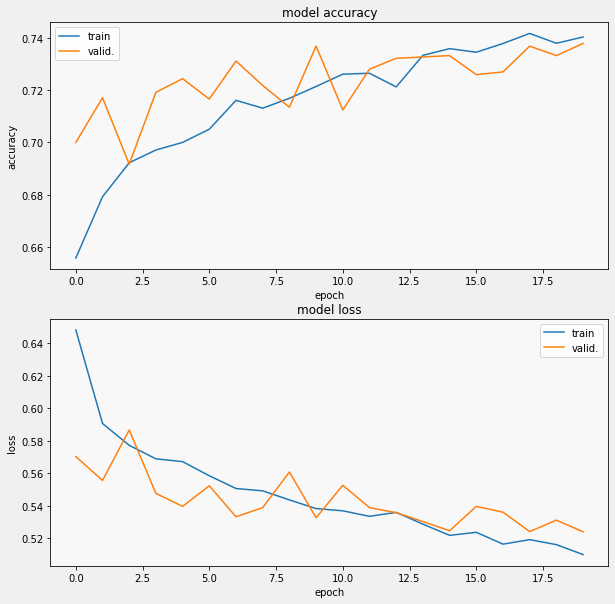

In [ ]:
vh.display_training_curves(s_mv_aug_history.history['accuracy'], s_mv_aug_history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(s_mv_aug_history.history['loss'], s_mv_aug_history.history['val_loss'], 'loss', 212)

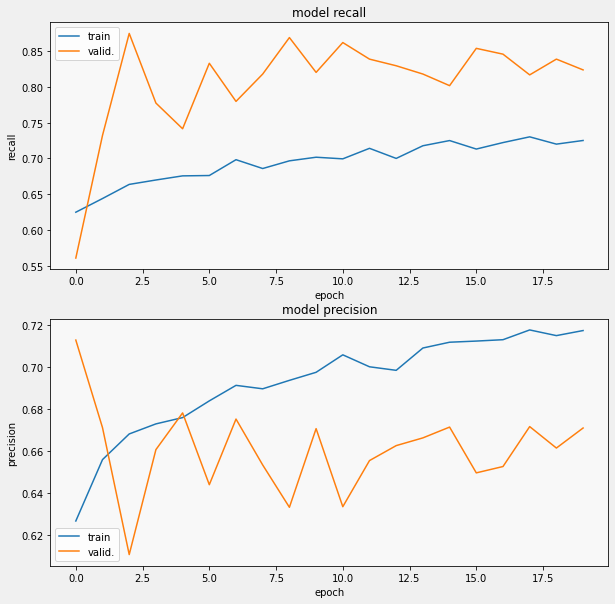

In [ ]:
vh.display_training_curves(s_mv_aug_history.history['recall'], s_mv_aug_history.history['val_recall'], 'recall', 211)
vh.display_training_curves(s_mv_aug_history.history['precision'], s_mv_aug_history.history['val_precision'], 'precision', 212)

##Finetuned model history

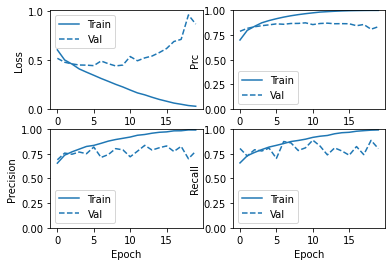

In [ ]:
vh.plot_metrics(mv_finetuned_history, metrics = ['loss', 'prc', 'precision', 'recall'])

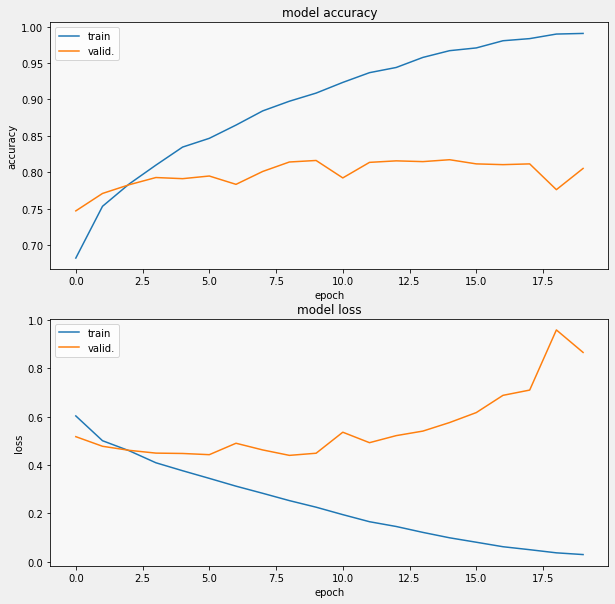

In [ ]:
vh.display_training_curves(mv_finetuned_history.history['accuracy'], mv_finetuned_history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(mv_finetuned_history.history['loss'], mv_finetuned_history.history['val_loss'], 'loss', 212)

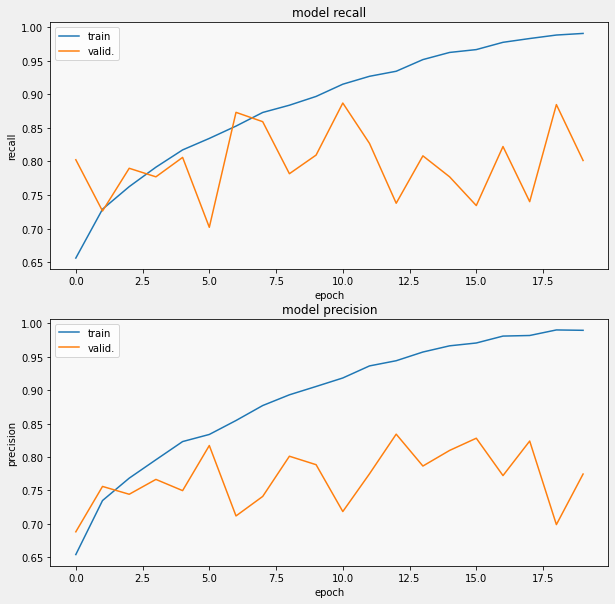

In [ ]:
vh.display_training_curves(mv_finetuned_history.history['recall'], mv_finetuned_history.history['val_recall'], 'recall', 211)
vh.display_training_curves(mv_finetuned_history.history['precision'], mv_finetuned_history.history['val_precision'], 'precision', 212)

##Finetuned model with data augmentation

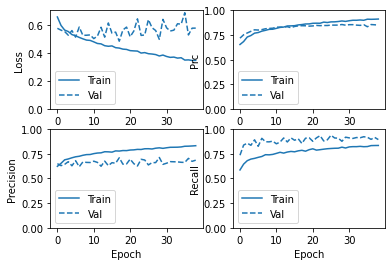

In [ ]:
vh.plot_metrics(mv_finetuned_aug_history, metrics = ['loss', 'prc', 'precision', 'recall'])

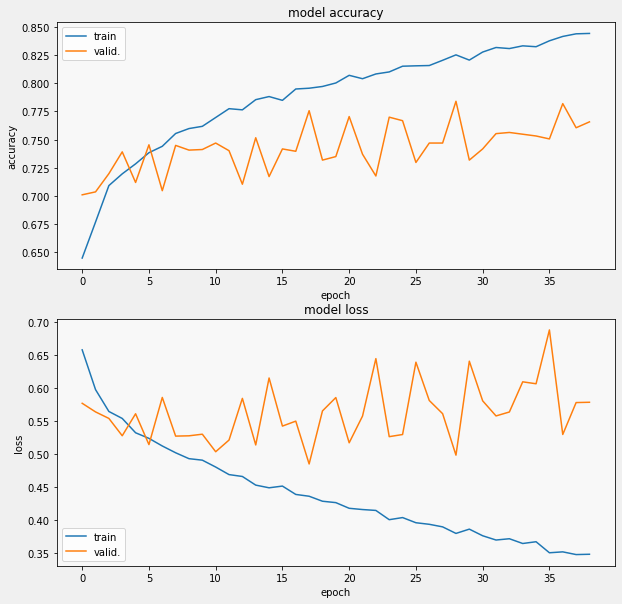

In [ ]:
vh.display_training_curves(mv_finetuned_aug_history.history['accuracy'], mv_finetuned_aug_history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(mv_finetuned_aug_history.history['loss'], mv_finetuned_aug_history.history['val_loss'], 'loss', 212)

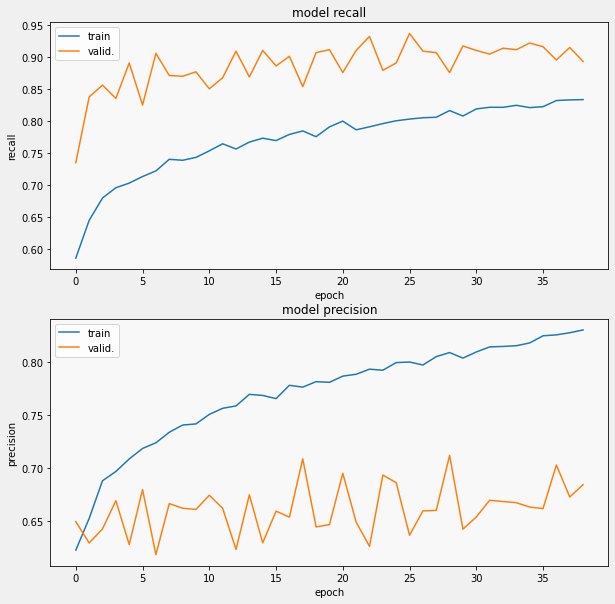

In [ ]:
vh.display_training_curves(mv_finetuned_aug_history.history['recall'], mv_finetuned_aug_history.history['val_recall'], 'recall', 211)
vh.display_training_curves(mv_finetuned_aug_history.history['precision'], mv_finetuned_aug_history.history['val_precision'], 'precision', 212)

#Model evaluation and Predictions

##Simple model

In [ ]:
saved_model = keras.models.load_model(simple_mobilenet_v2_path)

In [ ]:
results = saved_model.evaluate(test_ds)

for name, value in zip(saved_model.metrics_names, results):
  print(name, ': ', value)
print()

61/61 [==============================] - 6s 66ms/step - loss: 0.4303 - tp: 745.0000 - fp: 239.0000 - tn: 813.0000 - fn: 151.0000 - accuracy: 0.7998 - precision: 0.7571 - recall: 0.8315 - auc: 0.8863 - prc: 0.8668
loss :  0.4303038716316223
tp :  745.0
fp :  239.0
tn :  813.0
fn :  151.0
accuracy :  0.7997946739196777
precision :  0.7571138143539429
recall :  0.8314732313156128
auc :  0.8863087296485901
prc :  0.8667623996734619



Accuracy: 0.795833
Precision: 0.744186
Recall: 0.824356
F1 score: 0.782222
ROC AUC: 0.798670
[[412 121]
 [ 75 352]]
Non clickbaits Detected (True Negatives):  412
Non-Clickbaits Detected as Clickbaits (False Positives):  121
Clickbaits Detected as Non-clickbaits (False Negatives):  75
Clickbaits Detected (True Positives):  352
Total Non-clickbaits:  533
Total Clickbaits:  427



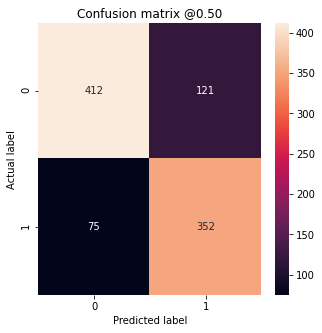

In [ ]:
test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(saved_model,test_ds, BATCH_SIZE=BATCH_SIZE, N=30)

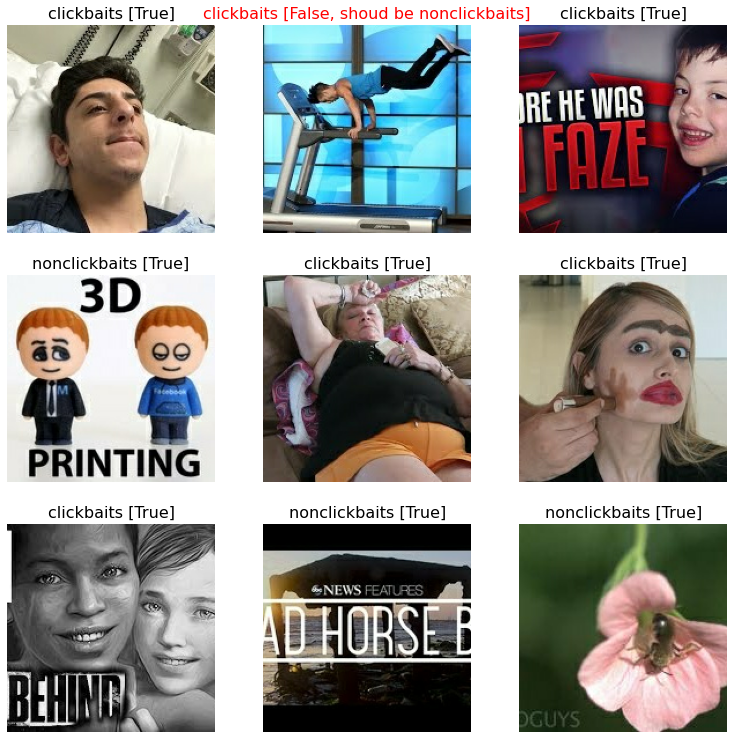

In [ ]:
vh.display_9_images_with_predictions(test_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)

##With Augment

In [ ]:
saved_model_with_aug = keras.models.load_model(simple_mobilenet_v2_with_data_aug_path)

In [ ]:
results = saved_model_with_aug.evaluate(test_ds)

for name, value in zip(saved_model_with_aug.metrics_names, results):
  print(name, ': ', value)
print()

61/61 [==============================] - 6s 69ms/step - loss: 0.4889 - tp: 752.0000 - fp: 313.0000 - tn: 739.0000 - fn: 144.0000 - accuracy: 0.7654 - precision: 0.7061 - recall: 0.8393 - auc: 0.8483 - prc: 0.8156
loss :  0.48887890577316284
tp :  752.0
fp :  313.0
tn :  739.0
fn :  144.0
accuracy :  0.7654004096984863
precision :  0.7061032652854919
recall :  0.8392857313156128
auc :  0.848268985748291
prc :  0.8155823349952698



Accuracy: 0.756250
Precision: 0.685934
Recall: 0.833724
F1 score: 0.752643
ROC AUC: 0.763954
[[370 163]
 [ 71 356]]
Non clickbaits Detected (True Negatives):  370
Non-Clickbaits Detected as Clickbaits (False Positives):  163
Clickbaits Detected as Non-clickbaits (False Negatives):  71
Clickbaits Detected (True Positives):  356
Total Non-clickbaits:  533
Total Clickbaits:  427



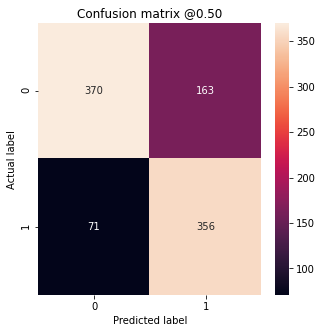

In [ ]:
test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(saved_model_with_aug,test_ds, BATCH_SIZE=BATCH_SIZE, N=30)

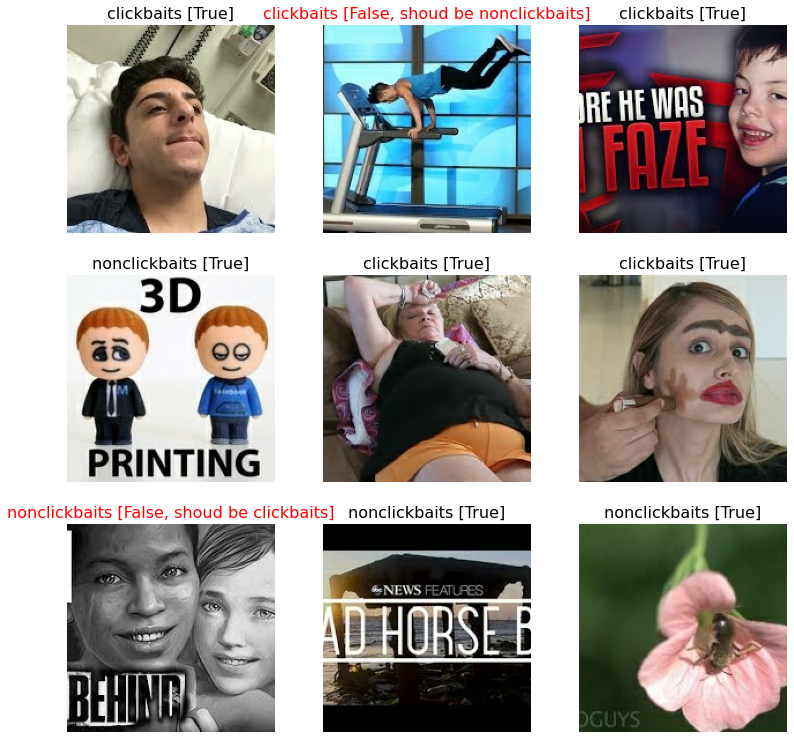

In [ ]:
vh.display_9_images_with_predictions(test_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)

##Finetuned model

In [ ]:
saved_model_finetuned = keras.models.load_model(mobilenet_v2_path)

In [ ]:
results = saved_model_finetuned.evaluate(test_ds)

for name, value in zip(saved_model_finetuned.metrics_names, results):
  print(name, ': ', value)
print()

61/61 [==============================] - 6s 64ms/step - loss: 0.4176 - tp: 727.0000 - fp: 184.0000 - tn: 868.0000 - fn: 169.0000 - accuracy: 0.8188 - precision: 0.7980 - recall: 0.8114 - auc: 0.9035 - prc: 0.8867
loss :  0.41757264733314514
tp :  727.0
fp :  184.0
tn :  868.0
fn :  169.0
accuracy :  0.8187885284423828
precision :  0.7980241775512695
recall :  0.8113839030265808
auc :  0.9035053849220276
prc :  0.8866987228393555



Accuracy: 0.812500
Precision: 0.771429
Recall: 0.822014
F1 score: 0.795918
ROC AUC: 0.813446
[[429 104]
 [ 76 351]]
Non clickbaits Detected (True Negatives):  429
Non-Clickbaits Detected as Clickbaits (False Positives):  104
Clickbaits Detected as Non-clickbaits (False Negatives):  76
Clickbaits Detected (True Positives):  351
Total Non-clickbaits:  533
Total Clickbaits:  427



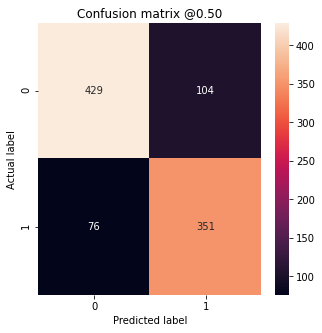

In [ ]:
test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(saved_model_finetuned, test_ds, BATCH_SIZE=BATCH_SIZE, N=30)

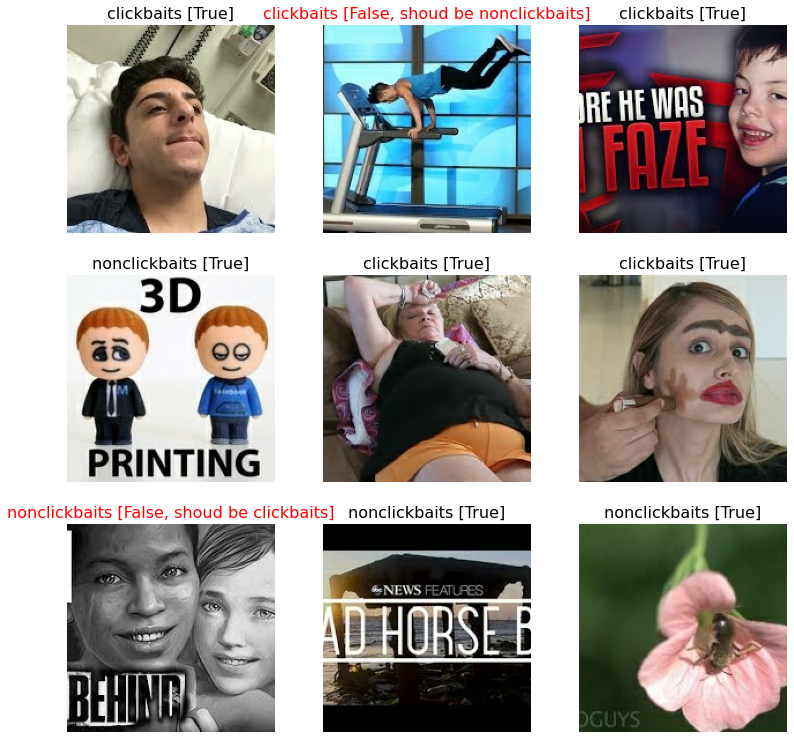

In [ ]:
vh.display_9_images_with_predictions(test_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)

##Finetuned model with data augmentation

In [ ]:
saved_model_finetuned_aug = keras.models.load_model(mobilenet_v2_aug_path)
results = saved_model_finetuned_aug.evaluate(test_ds)

for name, value in zip(saved_model_finetuned_aug.metrics_names, results):
  print(name, ': ', value)
print()

61/61 [==============================] - 6s 64ms/step - loss: 0.4562 - tp: 788.0000 - fp: 280.0000 - tn: 772.0000 - fn: 108.0000 - accuracy: 0.8008 - precision: 0.7378 - recall: 0.8795 - auc: 0.8926 - prc: 0.8729
loss :  0.45617982745170593
tp :  788.0
fp :  280.0
tn :  772.0
fn :  108.0
accuracy :  0.8008213639259338
precision :  0.737827718257904
recall :  0.8794642686843872
auc :  0.8925918936729431
prc :  0.8729226589202881



Accuracy: 0.778125
Precision: 0.700375
Recall: 0.875878
F1 score: 0.778356
ROC AUC: 0.787845
[[373 160]
 [ 53 374]]
Non clickbaits Detected (True Negatives):  373
Non-Clickbaits Detected as Clickbaits (False Positives):  160
Clickbaits Detected as Non-clickbaits (False Negatives):  53
Clickbaits Detected (True Positives):  374
Total Non-clickbaits:  533
Total Clickbaits:  427



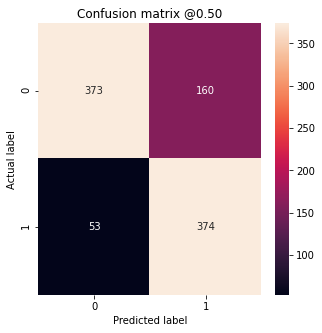

In [ ]:
test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(saved_model_finetuned_aug, test_ds, BATCH_SIZE=BATCH_SIZE, N=30)

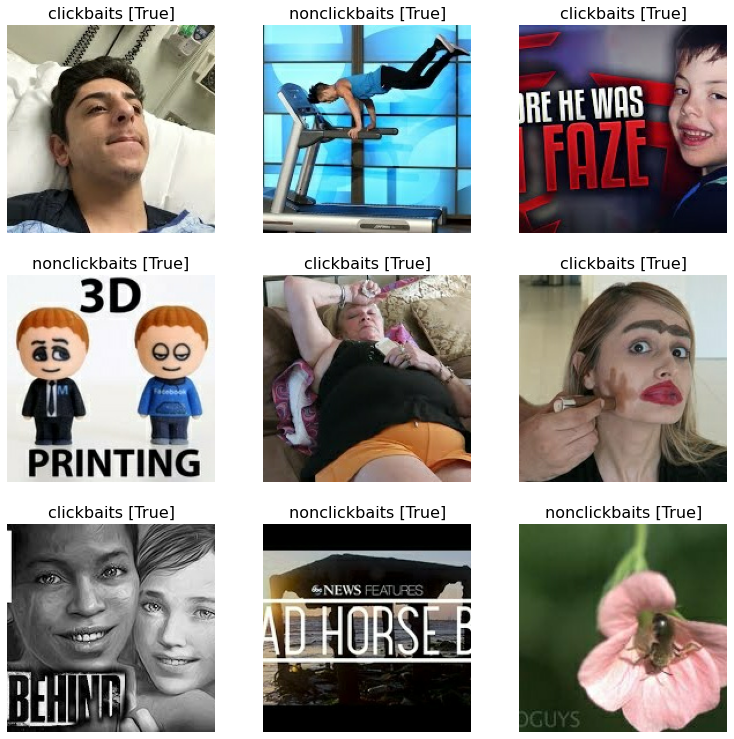

In [ ]:
vh.display_9_images_with_predictions(test_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)

#Benchmarking the model with Invid2.0 dataset

##Load benchmarking dataset

In [ ]:
invid_tfrec_root = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data'
invid_data_path = os.path.join(invid_tfrec_root,'image_text')
invid_data_path

'/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/image_text'

In [ ]:
invid_filenames = tf.io.gfile.glob(invid_data_path + "*.tfrec")
len(invid_filenames)

4

In [ ]:
#instantiate read_data utility
read_data = read_tfrec_data(invid_data_path,TARGET_SIZE=TARGET_SIZE, MODE=0, BATCH_SIZE=10)

In [ ]:
invid_test_ds = read_data.get_batched_dataset(invid_filenames, train=False)

In [ ]:
for image, class_num in invid_test_ds.take(2):
  for i in range(10):
    print(f"Image shape {image[i].shape}, Class={class_num[i]}, Label={CLASSES[class_num[i]]}")

Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), C

##Evaluate and predict on benchmarking dataset

###Simple model

In [ ]:
#saved_model = keras.models.load_model(simple_mobilenet_v2_path)
results = saved_model.evaluate(invid_test_ds)

for name, value in zip(saved_model.metrics_names, results):
  print(name, ': ', value)
print()

17/17 [==============================] - 1s 34ms/step - loss: 1.2325 - tp: 29.0000 - fp: 29.0000 - tn: 40.0000 - fn: 65.0000 - accuracy: 0.4233 - precision: 0.5000 - recall: 0.3085 - auc: 0.4030 - prc: 0.5314
loss :  1.232541799545288
tp :  29.0
fp :  29.0
tn :  40.0
fn :  65.0
accuracy :  0.42331287264823914
precision :  0.5
recall :  0.3085106313228607
auc :  0.403021901845932
prc :  0.5313682556152344



Accuracy: 0.412500
Precision: 0.500000
Recall: 0.308511
F1 score: 0.381579
ROC AUC: 0.434558
[[37 29]
 [65 29]]
Non clickbaits Detected (True Negatives):  37
Non-Clickbaits Detected as Clickbaits (False Positives):  29
Clickbaits Detected as Non-clickbaits (False Negatives):  65
Clickbaits Detected (True Positives):  29
Total Non-clickbaits:  66
Total Clickbaits:  94



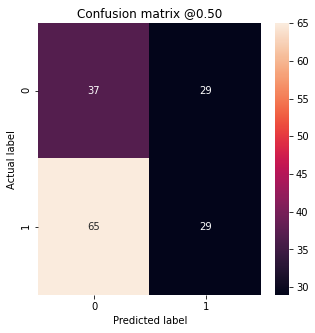

In [ ]:
test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(saved_model, invid_test_ds, BATCH_SIZE=10, N=16)

###Benchmarking with data augmentation model

In [ ]:
#saved_model_with_aug = keras.models.load_model(simple_mobilenet_v2_with_data_aug_path)
results = saved_model_with_aug.evaluate(invid_test_ds)
for name, value in zip(saved_model_with_aug.metrics_names, results):
  print(name, ': ', value)
print()

17/17 [==============================] - 1s 33ms/step - loss: 0.9673 - tp: 39.0000 - fp: 41.0000 - tn: 28.0000 - fn: 55.0000 - accuracy: 0.4110 - precision: 0.4875 - recall: 0.4149 - auc: 0.3792 - prc: 0.5367
loss :  0.9672530293464661
tp :  39.0
fp :  41.0
tn :  28.0
fn :  55.0
accuracy :  0.4110429584980011
precision :  0.48750001192092896
recall :  0.41489362716674805
auc :  0.37920138239860535
prc :  0.5366889238357544



Accuracy: 0.400000
Precision: 0.487500
Recall: 0.414894
F1 score: 0.448276
ROC AUC: 0.396841
[[25 41]
 [55 39]]
Non clickbaits Detected (True Negatives):  25
Non-Clickbaits Detected as Clickbaits (False Positives):  41
Clickbaits Detected as Non-clickbaits (False Negatives):  55
Clickbaits Detected (True Positives):  39
Total Non-clickbaits:  66
Total Clickbaits:  94



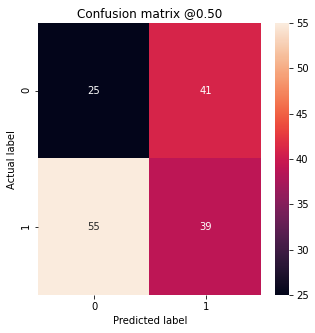

In [ ]:
test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(saved_model_with_aug, invid_test_ds, BATCH_SIZE=10, N=16)

###Benchmarking with Finetuned model

In [ ]:
#saved_model_finetuned = keras.models.load_model(mobilenet_v2_path)
results = saved_model_finetuned.evaluate(invid_test_ds)
for name, value in zip(saved_model_finetuned.metrics_names, results):
  print(name, ': ', value)
print()

17/17 [==============================] - 1s 29ms/step - loss: 1.4950 - tp: 23.0000 - fp: 29.0000 - tn: 40.0000 - fn: 71.0000 - accuracy: 0.3865 - precision: 0.4423 - recall: 0.2447 - auc: 0.3627 - prc: 0.5023
loss :  1.4950329065322876
tp :  23.0
fp :  29.0
tn :  40.0
fn :  71.0
accuracy :  0.38650307059288025
precision :  0.4423076808452606
recall :  0.24468085169792175
auc :  0.3627042770385742
prc :  0.5023145079612732



Accuracy: 0.381250
Precision: 0.450980
Recall: 0.244681
F1 score: 0.317241
ROC AUC: 0.410219
[[38 28]
 [71 23]]
Non clickbaits Detected (True Negatives):  38
Non-Clickbaits Detected as Clickbaits (False Positives):  28
Clickbaits Detected as Non-clickbaits (False Negatives):  71
Clickbaits Detected (True Positives):  23
Total Non-clickbaits:  66
Total Clickbaits:  94



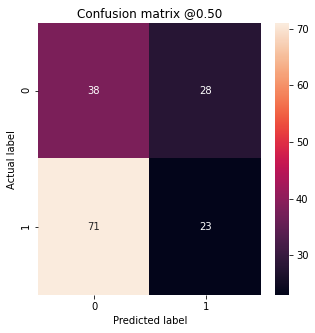

In [ ]:
test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(saved_model_finetuned, invid_test_ds, BATCH_SIZE=10, N=16)

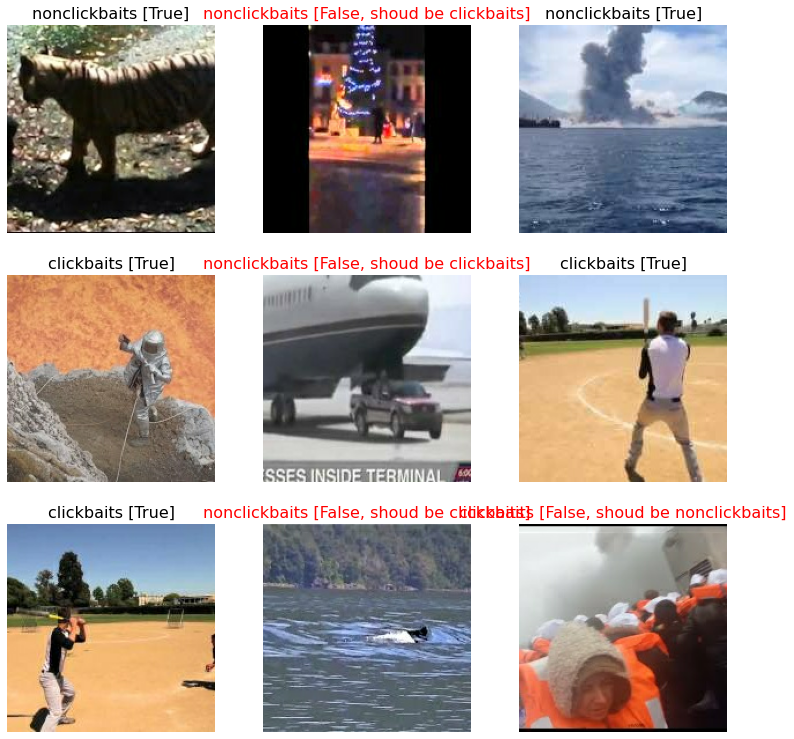

In [ ]:
vh.display_9_images_with_predictions(test_image, y_pred, y_true, CLASSES=CLASSES)

###Benchmarking with Finetuned model with augmentation

In [ ]:
#saved_model_finetuned_aug = keras.models.load_model(mobilenet_v2_aug_path)
results = saved_model_finetuned_aug.evaluate(invid_test_ds)

for name, value in zip(saved_model_finetuned_aug.metrics_names, results):
  print(name, ': ', value)
print()

17/17 [==============================] - 1s 30ms/step - loss: 1.2491 - tp: 34.0000 - fp: 44.0000 - tn: 25.0000 - fn: 60.0000 - accuracy: 0.3620 - precision: 0.4359 - recall: 0.3617 - auc: 0.3384 - prc: 0.5029
loss :  1.2490772008895874
tp :  34.0
fp :  44.0
tn :  25.0
fn :  60.0
accuracy :  0.3619631826877594
precision :  0.43589743971824646
recall :  0.3617021143436432
auc :  0.3384212255477905
prc :  0.5029420852661133



Accuracy: 0.356250
Precision: 0.441558
Recall: 0.361702
F1 score: 0.397661
ROC AUC: 0.355093
[[23 43]
 [60 34]]
Non clickbaits Detected (True Negatives):  23
Non-Clickbaits Detected as Clickbaits (False Positives):  43
Clickbaits Detected as Non-clickbaits (False Negatives):  60
Clickbaits Detected (True Positives):  34
Total Non-clickbaits:  66
Total Clickbaits:  94



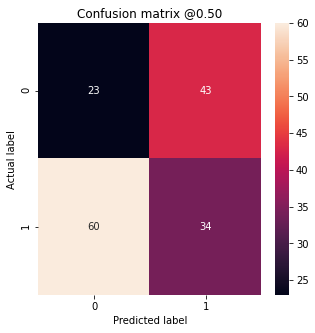

In [ ]:
test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(saved_model_finetuned_aug, invid_test_ds, BATCH_SIZE=10, N=16)